## Introducción.

El dataset trabajado cuenta con un registro de 50 millones de manos jugadas de "BlackJack" usando un simulador. Cada registro cuenta con 12 columnas, de las cuales se valerá nuestra red neuronal para predecir la acción a tomar:
- Pedir una carta (HIT).
- No pedir otra carta (STAND).

## Parte 1 - Análisis de la base de datos.

### 1. Descripción de columnas.

Nuestro dataset cuenta con muchas columnas que terminaremos reduciendo a las que consideramos mas relevantes. Sin embargo, resumiremos la utilidad de la totalidad de ellas:
- "Shoe id": Es un identificador del mazo utilizado (del 1 al 8).
- "Cards remaining": Son las cartas restantes del mazo al empezar la ronda.
- "Dealer up": Es la carta visible del "dealer" al empezar la ronda.
- "Initial hand": Son las 2 cartas dadas al jugador.
- "Dealer final": Cartas con las que termina el dealer al final de la ronda.
- "Dealer final value":  Es el valor de las cartas mencionadas en la columna anterior.
- "Player final": Al igual que dealer final, son las cartas con las que termina el jugador.
- "Player final value": La suma del valor de las cartas del jugador.
- "Actions taken": Es la acción que toma el el jugador, "H" o "S".
- "Run count": Identificador de la ronda a jugar.

### 2. Analisis de correlaciones.

Por un lado, consideramos varias columnas como poco impactantes, como por ejemplo:
- Shoe id: El identificador del mazo no afecta a la estrategia del juego.
- Run count: No afecta el numero de ronda jugada con la decisión a tomar.
- Cards remaining: A menos que se esté haciendo un conteo de cartas (lo cual es un analisis muy avanzado), no suele impactar en la decisión final.

Ahora bien, hay columnas que representan correlacionves clave para la decisión a tomar:
- Initial hand => Actions taken: La correlación en este caso es alta(positiva o negativamente). Las manos de 17 a 21 correlacionan con STAND, mientras que las menores a 11 se correlacionan con HIT
- Dealer up => Actions taken: La correlación es alta y negativa, ya que si el dealer tiene una mano "alta", el jugador tenderá a hacer HIT, y si la mano del dealer es "baja", el jugador hará STAND.



In [ ]:
# Importar librerias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Me interesa: ; dealer_up; initial_hand; actions_taken
columnas = ['dealer_up','initial_hand','actions_taken']
df = pd.read_csv("csv_reducido",usecols=columnas)
df.head(5)

,dealer_up,initial_hand,actions_taken
0,10,"[6, 3]","[['H', 'H']]"
1,10,"[10, 5]",[['R']]
2,2,"[6, 8]",[['S']]
3,8,"[7, 3]",[['D']]
4,6,"[10, 5]",[['S']]


### 3 - Análisis de factibilidad.

Consideramos el dataset elegido como idóneo para entrar una red neuronal, y sobretodo con las columnas seleccionadas.
Dichas columnas son predictoras naturales de la acción que se tomará. A su vez, esta columna de decisión es una variable objetivo binaria y categórica, ideal para la tarea de clasificación.

Dicho esto, lo que en última medida predecirá la red, es la acción ideal a tomar, una vez presentada la carta del dealer así como las del jugador.

### 4 - Datos atípicos y limpieza.

Al regirnos a las reglas mismas del Blackjack, es imposible encontrar Outliers por definición.


### 5 - Transformaciones preliminares.

Los datos presentados originalmente no servirán de mucho, puesto que tenemos listas que la red neuronal no entenderá, así como strings, por lo que debemos convertir initial_hand y actions_taken en variables que la red sí pueda comprender.
En este caso sumaremos los valores de las cartas de initial_hand para llegar a el valor total del jugador. Con respecto a actions_taken, nos quedaremos solamente con HIT y STAND, que son las 2 acciones mas comunes, y les daremos un valor binario, ideal para la predicción.

In [86]:
# Sumar toda la initial hand para que sea un valor
df['hand_value'] = df['initial_hand'].apply(lambda x: sum(eval(x)) if isinstance(x, str) else sum(x))

# Solo me interesa la primera accion, si Hitteo, o si hizo Stay
acciones_validas = ['H','S']


def get_accion_valida(actions):
    try:
        actions = eval(actions)[0] if isinstance(actions, str) else actions[0]
    except Exception:
        return None
    for action in actions:
        if action in acciones_validas:
            return action
    return None

# Recorro la columna actions taken y aplico la funcion para filtrar y le asigno un valor binario
df['first_action'] = df['actions_taken'].apply(get_accion_valida)
df = df[df['first_action'].notnull()]
df['action'] = df['first_action'].map({'S':0,'H':1})

# Creo ya las columnas con todos valores listos para interpretarse
inputs = df[['dealer_up','hand_value']]
outputs = df[['action']]
df_preview = pd.concat([inputs, outputs], axis=1)
print(df_preview.head())



   dealer_up  hand_value  action
0         10           9       1
2          2          14       0
4          6          15       0
5         11           9       1
8          6          12       0


El siguiente paso será normalizar los datos que tenemos. 
Aplicaremos el **MinMaxScaler** de **sklearn**, que lo que hará será convertir nuestro hand value a valores de entre 0 y 1, pero teniendo en cuenta que los valores originales iban de entre 4 a 21.
Tambien escalaremos el dealer_up de la misma forma, pero teniendo en cuenta en este caso que los valores originales iban de 2 a 11. Es decir, la escala que se utiliza para convertir los valores entre 0 y 1 será diferente en ambos casos.

In [87]:

scaler = MinMaxScaler()
X = scaler.fit_transform(df_preview[['dealer_up', 'hand_value']])

# La salida ya es binaria, asi que no hace falta normalizarla

#Inputs normalizadas
df_inputs = pd.DataFrame(X, columns=['dealer_up_normalizado', 'hand_value_normalizado'])

#Concateno con la action
df_normalizado =  pd.concat([df_inputs, df_preview['action'].reset_index(drop=True)], axis=1)

df_normalizado.head()



,dealer_up_normalizado,hand_value_normalizado,action
0,0.888889,0.294118,1
1,0.000000,0.588235,0
2,0.444444,0.647059,0
3,1.000000,0.294118,1
4,0.444444,0.470588,0


## PARTE 2 - DESARROLLO DE LA RED NEURONAL

Ya con los datos preparados vamos a comenzar haciendo un test de presicion con la red sin entrenar aplicando Forward Propagation

# Parte 2 - Desarrollo de la Red Neuronal


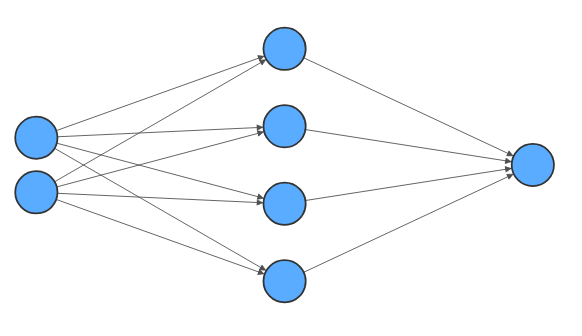

## 1. Arquitectura de la red
Nuestra **Red Neuronal** es una red neuronal monocapa de clasificacion, es decir, cuenta solamente con una capa oculta de entrenamiento, con lo que nos quedara:
- Capa de entrada: 2 neuronas (2 entradas)
- Capa oculta: 4 neuronas donde sucede la matematica necesaria para entrenar la red
- Capa de salida: 1 neurona que devolvera una salida binaria, en este caso, si hacer HIT o STAY

En un principio habiamos usado la funcion de activacion ReLu para la entrada y la sigmoide para la salida, pues era lo mas normal, pero luego de analisis y comenzar a entrenar la red, nos dimos cuenta que en nuestro caso de estudio, ReLu no nos aporta nada, pues no tenemos valores negativos.

Entonces, para la capa oculta nos decantamos a usar la funcion activacion **Tangente Hiperbolica** o **tanh**, que hace que los datos hagan una curva sigmoidal entre -1 y 1, logrando introducir a nuestro conjunto una no linealidad mas real.

Para la salida si mantuvimos la decision de utilizar la funcion de activacion **logistica** para poder obtener valores entre 0 y 1 y asi lograr clasificar la salida, si es menor a 0.5 resulta en un *Stand* y si es mayor en un *Hit*

## 2. y 3. Implementacion de la red y entrenamiento

In [88]:
# Con 100.000 datos, usamos el 20% como conjunto de prueba
X_train, X_test, Y_train, Y_test = train_test_split(df_inputs, outputs, test_size=0.2)

# Guardo el numero de registros de entrenamiento
n = X_train.shape[0]

# Construimos una red neuronal simple con pesos y sesgos
w_hidden = np.random.rand(4, 2)  # Tenemos 2 entradas, son las dimensiones de la matriz y 4 neuronas
w_output = np.random.rand(1, 4)

b_hidden = np.random.rand(4, 1)
b_output = np.random.rand(1, 1)

# Defino las funciones activación
tanh = lambda x: np.tanh(x) # Como no hay datos negativos, decidimos usar la funcion de activacion de Tangente Hiperbolica
logistic = lambda x: 1 / (1 + np.exp(-x))  # Es la función sigmoide, convierte todos los valores de salida a un número entre 1 y 0

# Defino la función forward_prop, que es la fórmula tradicional de Descenso de Gradiente Estocástico
def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden  # Aplico la fórmula con la entrada
    A1 = tanh(Z1)                 # Primera función activación
    Z2 = w_output @ A1 + b_output # Hago la fórmula con la salida anterior activada
    A2 = logistic(Z2)             # Salida activada
    return Z1, A1, Z2, A2

# Calculo de precisión
test_predictions = forward_prop(X_test.T)[3]  # Me interesa solo la capa de salida (A2)

test_comparisons = np.equal(test_predictions >= 0.5, Y_test.values.reshape(1, -1)).astype(int) # Devuelve true si la prediccion fue mayor a 0.5, y asegura q los valores de Y_test tengan la misma forma
accuracy = np.mean(test_comparisons)
print("ACCURACY: ", accuracy)



ACCURACY:  0.43758712457229754


Como vemos en el resultado de la acurracy, nuestra red no entrenada acierta menos de la mitad de las veces, que no es ideal, por lo que ahora vamos a hacer **Backpropagation**, aplicando **descenso de gradiente estocastico** para entrenar la red

In [89]:
# En primer lugar vamos a declarar una taza de aprendizaje para nuestra red
L = 0.01

# Luego, derivamos las funciones de activacion, que nos serviran para calcular derivadas parciales a la hora de definir BackPropagation
d_tanh = lambda x: 1 - np.tanh(x)**2
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2


# Definimos Backpropagation
def backward_prop(Z1, A1, Z2, A2, X, Y):
    dC_dA2 = 2 * A2 - 2 * Y
    dA2_dZ2 = d_logistic(Z2)
    dZ2_dA1 = w_output
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dA1_dZ1 = d_tanh(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T

    dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2

    dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1

    dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T

    dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2

# Definimos el calculo de la perdida entre las predicciones de la red y los resultados verdaderos, en redes de clasificacion binaria se suele utilizar la funcion "Entropia cruzada binaria"
def compute_loss(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    m = y_true.shape[1]
    epsilon = 1e-8  # Para evitar log(0)
    loss = -1/m * np.sum(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    return loss


# Listas para luego graficar
presicion_train = [] 
presicion_test = []
loss_train_list = []
loss_test_list = []

# Ejecutamos el Descenso de gradiente
for i in range(50_000):
    # Elijo aleatoriamente uno de los datos dedicados a entrenamiento (el otro 80%)
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train.iloc[idx].values.T # Forma (2,1)
    Y_sample = Y_train.iloc[idx].values.reshape(1,1) # Forma (1,1)

    # Paso los datos seleccionados por la red neuronal de forma aleatoria
    Z1, A1, Z2, A2 = forward_prop(X_sample)

    # Aplico retropropagacion para distribuir errores y devolver pendientes para los pesos y los sesgos
    dW1, dB1, dW2, dB2 = backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

    # Actualizo los pesos y los sesgos
    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_output -= L * dW2
    b_output -= L * dB2

    if i % 1000 == 0:
    # Cálculo de precisión del train
        train_predictions = forward_prop(X_train.transpose())[3]
        train_predictions = (train_predictions >= 0.5).astype(int)  # Convertir las predicciones en valores binarios
        accuracy_train = np.mean(train_predictions == Y_train.values.reshape(1, -1))  # Calcular la precisión comparando las predicciones con los valores reales
        presicion_train.append(accuracy_train)

        # Cálculo de precisión del test
        test_predictions = forward_prop(X_test.transpose())[3]
        test_predictions = (test_predictions >= 0.5).astype(int)  # Convertir las predicciones en valores binarios
        accuracy_test = np.mean(test_predictions == Y_test.values.reshape(1, -1))  # Calcular la precisión comparando las predicciones con los valores reales
        presicion_test.append(accuracy_test)


          # Cálculo de pérdida para entrenamiento
        A2_train = forward_prop(X_train.T)[3]  # Salida final
        loss_train = compute_loss(A2_train, Y_train.values.reshape(1, -1))
        loss_train_list.append(loss_train)

        # Cálculo de pérdida para test
        A2_test = forward_prop(X_test.T)[3]
        loss_test = compute_loss(A2_test, Y_test.values.reshape(1, -1))
        loss_test_list.append(loss_test)



# Calculo de precision actualizado con la red entrenada
test_predictions = forward_prop(X_test.T)[3]
test_comparisons = np.equal(test_predictions >= 0.5, Y_test.values.reshape(1, -1)).astype(int)
accuracy = np.mean(test_comparisons)
print("ACCURACY: ", accuracy)




ACCURACY:  0.8886072741097453


Grafico de Acurracy Train y Acurracy Test, para ver como la red neuronal aprende, en ambos graficos, se utiliza el **conjunto de test** como **set de validacion**.

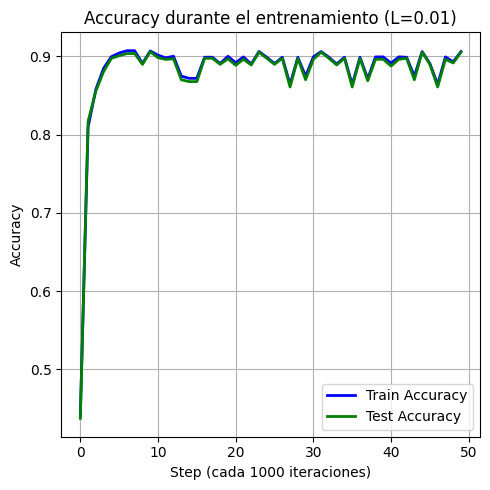

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))  
plt.plot(presicion_train, label='Train Accuracy', color='blue', lw=2)  # Precisión del set de entrenamiento
plt.plot(presicion_test, label='Test Accuracy', color='green', lw=2)  # Precisión del set de testeo

plt.title(f'Accuracy durante el entrenamiento (L={L})')  
plt.xlabel('Step (cada 1000 iteraciones)')  
plt.ylabel('Accuracy') 
plt.legend()  
plt.grid(True)  
plt.tight_layout()  
plt.show()  


Podemos observar como el grafico comienza aproximadamente en 0.44, que es el acurracy calculado por el forward prop de la red sin entrenar. Cerca de las primeras 1000 iteraciones ya llego a una precision casi del 90%, llegando mientras avanza a un maximo de 91-92%. 

Grafico de la funcion perdida, para medir la discrepancia entre las probabilidades predichas y las probabilidades reales

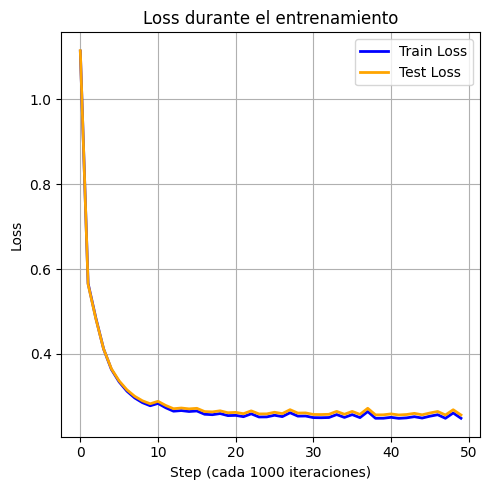

In [91]:
plt.figure(figsize=(5,5)) 
plt.plot(loss_train_list, label='Train Loss', color='blue', lw=2)  # Grafica la pérdida del entrenamiento
plt.plot(loss_test_list, label='Test Loss', color='orange', lw=2)  # Grafica la pérdida del test

plt.title('Loss durante el entrenamiento')  
plt.xlabel('Step (cada 1000 iteraciones)')  
plt.ylabel('Loss')  
plt.legend()  
plt.grid(True)  
plt.tight_layout()  
plt.show()  

Al inicio, la perdida es muy alta, el modelo todavia no aprendio, pero a partir del step 5 (5000 iteraciones), podemos ver como la perdida se establece en un valor proximo a 0.3

## 4. Analisis de Overfitting

Nuestro modelo a analizar, basandonos en los graficos de acurracy y loss, no presenta **overfitting**, las curvas de entrenamiento y test son casi similares, superponiendose en algunas ocasiones.
Si hubiese **overfitting**, nos dariamos cuenta si nuestro acurracy de validacion se estanca o baja mientras que el de entrenamiento sigue subiendo. El algoritmo en ese caso aprende a recordar muchos ejemplos similares, en vez de aprender a notar caracteristicas y patrones a seguir.

Para identificar donde comienza el overfitting para corregirlo hay que observar los graficos, si a partir de ciertas epochs las curvas de ambos graficos empiezan a diverger, podemos empezar a actuar ahi, reduciendo la cantidad de iteraciones hasta el punto en el que empieza a fallar. Tambien podriamos automatizarlo haciendo que despues de N iteraciones se detenga el entrenamiento usando frameworks especializados en machine learning.
Ademas, podriamos revisar si la limpieza de datos fue suficiente, si la red empieza a memorizar datos puede ser que en el DataSet elegido haya muchos datos repetidos que hagan confundir a la red, asi que limpiar los datos puede ayudarnos a reducir el ruido, eliminar casos atipicos y simplificar el espacio de entrada para que haya menos probabilidad de **overfitting**

## Adicional: Prueba de la red con elementos aleatorios del DataSet

In [151]:


features_norm = ['dealer_up_normalizado', 'hand_value_normalizado']
features_orig = ['dealer_up', 'hand_value']

posiciones_aleatorias = np.random.choice(len(df_normalizado), size=10, replace=False)

for pos in posiciones_aleatorias:
    X_sample_norm = df_normalizado.iloc[pos][features_norm].values.reshape(1, -1).T

    _, _, _, A2 = forward_prop(X_sample_norm)
    prediccion = (A2 >= 0.5).astype(int)

    datos_originales = df_preview.iloc[pos][features_orig]
    accion_real = df_preview.iloc[pos]['action']

    print(f"Fila posición {pos}")
    print(f"dealer_up: {datos_originales['dealer_up']}")
    print(f"hand_value: {datos_originales['hand_value']}")
    print("Activación salida A2:", A2.flatten())
    print("Predicción (acción):", prediccion.item())
    print("Acción real en el dataframe:", accion_real)
    print("\n")



Fila posición 17921
dealer_up: 7
hand_value: 15
Activación salida A2: [0.40858939]
Predicción (acción): 0
Acción real en el dataframe: 1


Fila posición 28183
dealer_up: 6
hand_value: 12
Activación salida A2: [0.83813853]
Predicción (acción): 1
Acción real en el dataframe: 0


Fila posición 20507
dealer_up: 7
hand_value: 19
Activación salida A2: [0.03726789]
Predicción (acción): 0
Acción real en el dataframe: 0


Fila posición 356
dealer_up: 7
hand_value: 17
Activación salida A2: [0.11909639]
Predicción (acción): 0
Acción real en el dataframe: 0


Fila posición 8733
dealer_up: 10
hand_value: 5
Activación salida A2: [0.99710269]
Predicción (acción): 1
Acción real en el dataframe: 1


Fila posición 14514
dealer_up: 10
hand_value: 19
Activación salida A2: [0.1532412]
Predicción (acción): 0
Acción real en el dataframe: 0


Fila posición 4247
dealer_up: 8
hand_value: 17
Activación salida A2: [0.19910263]
Predicción (acción): 0
Acción real en el dataframe: 0


Fila posición 27490
dealer_up: 